In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from scipy.ndimage import median_filter
from scipy.special import factorial
from scipy.stats import poisson
from astropy.stats import sigma_clipped_stats
import scipy as sp
import math
from scipy.optimize import curve_fit
import matplotlib
params={
    'text.usetex':True,
    'font.family':'serif',
    'xtick.minor.visible':True,
    'ytick.minor.visible':True,
    'xtick.top':True,
    'ytick.left':True,
    'ytick.right':True,
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True
}
matplotlib.rcParams.update(params)
%matplotlib inline

In [2]:
def openlc(filename):
    hdul = fits.open(filename)
    data = hdul[1].data
    hdul.close()
    return data

def filter_and_detrend(filename, start, end, polyorder=3):
    data = openlc(filename)
    south_atlantic_start = np.where(data['RATE'] == 0)[0][0]
    south_atlantic_end = np.where(data['RATE'] == 0)[0][-1]
    if end<south_atlantic_start:
        data['RATE'][start:end] -= (np.mean([data['RATE'][:start]]) + np.mean(data['RATE'][end:south_atlantic_start] + np.mean(data['RATE'][south_atlantic_end:])))/3
        data['RATE'][:start] -= savgol_filter(data['RATE'][:start], 101, polyorder)
        data['RATE'][end:south_atlantic_start] -= savgol_filter(data['RATE'][end:south_atlantic_start], 101, polyorder)
        data['RATE'][south_atlantic_end:] -= savgol_filter(data['RATE'][south_atlantic_end:], 101, polyorder)
    elif start>south_atlantic_end:
        data['RATE'][start:end] -= (np.mean([data['RATE'][:south_atlantic_start]]) + np.mean(data['RATE'][south_atlantic_end:start] + np.mean(data['RATE'][end:])))/3
        data['RATE'][:south_atlantic_start] -= savgol_filter(data['RATE'][:south_atlantic_start], 101, polyorder)
        data['RATE'][south_atlantic_end:start] -= savgol_filter(data['RATE'][south_atlantic_end:start], 101, polyorder)
        data['RATE'][end:] -= savgol_filter(data['RATE'][end:], 101, polyorder)
    else:
        print('Inputted start and end times are not valid')
    return data, south_atlantic_start, south_atlantic_end

def snr_rms(filename, start, end, polyorder=3):
    data, south_atlantic_start, south_atlantic_end = filter_and_detrend(filename, start, end, polyorder)
    if end<south_atlantic_start:
        rms = np.sqrt(np.mean(data['RATE'][:start]**2))   #ignoring the noise after the GRB
        signal = np.max(data['RATE'][start:end])
        snr = signal/rms
    elif start>south_atlantic_end:
        rms = np.sqrt(np.mean(data['RATE'][:south_atlantic_start]**2+data['RATE'][south_atlantic_end:start]**2))
        signal = np.max(data['RATE'][start:end])
        snr = signal/rms
    else:
        print('Inputted start and end times are not valid')
        snr = 0
    return snr

def snr_abs(filename, start, end, polyorder=3):
    data, south_atlantic_start, south_atlantic_end = filter_and_detrend(filename, start, end, polyorder)
    if end<south_atlantic_start:
        abs = np.mean(np.abs(data['RATE'][:start]))
        signal = np.max(data['RATE'][start:end])
        snr = signal/abs
    elif start>south_atlantic_end:
        abs = (np.mean(np.abs(data['RATE'][:south_atlantic_start]))+np.mean(np.abs(data['RATE'][south_atlantic_end:start])))/2
        signal = np.max(data['RATE'][start:end])
        snr = signal/abs
    else:
        print('Inputted start and end times are not valid')
        snr = 0
    return snr

def gaussian(x, A, m, s, c):
    return A*np.exp(-(x-m)**2/(2*s**2)) + c

def snr_gauss(filename, start, end, polyorder=3):
    data, south_atlantic_start, south_atlantic_end = filter_and_detrend(filename, start, end, polyorder)
    if end<south_atlantic_start:
        total_noise = np.concatenate((data['RATE'][:start], data['RATE'][end:south_atlantic_start], data['RATE'][south_atlantic_end:]))
        n, bins = np.histogram(total_noise, bins=80)
        bin_center = np.array([0.5*(bins[i]+bins[i+1]) for i in range(len(bins)-1)])
        popt, pcov = curve_fit(gaussian, bin_center, n, p0=[np.max(n), np.mean(total_noise), np.std(total_noise), 0])
        signal = np.max(data['RATE'][start:end])
        noise = popt[1]+3*popt[2]
        snr = signal/noise
    elif start>south_atlantic_end:
        total_noise = np.concatenate((data['RATE'][:south_atlantic_start], data['RATE'][south_atlantic_end:start], data['RATE'][end:]))
        n, bins = np.histogram(total_noise, bins=80)
        bin_center = np.array([0.5*(bins[i]+bins[i+1]) for i in range(len(bins)-1)])
        popt, pcov = curve_fit(gaussian, bin_center, n, p0=[np.max(n), np.mean(total_noise), np.std(total_noise), 0])
        signal = np.max(data['RATE'][start:end])
        noise = popt[1]+3*popt[2]
        snr = signal/noise
    else:
        print('Inputted start and end times are not valid')
        snr = 0
        total_noise = 0
        popt = [0]
        bin_center = 0
    return snr, total_noise, bin_center, popt

def snr_counts(filename, start, end, polyorder=3):
    data, south_atlantic_start, south_atlantic_end = filter_and_detrend(filename, start, end, polyorder)
    duration_lc = data['TIME'][-1]-data['TIME'][0]
    duration_burst = data['TIME'][end]-data['TIME'][start]
    duration_sao = data['TIME'][south_atlantic_end]-data['TIME'][south_atlantic_start]
    duration_noise = duration_lc-duration_burst-duration_sao
    if end<south_atlantic_start:
        signal = np.sum(data['RATE'][start:end])/duration_burst
        noise = np.sum(np.abs(data['RATE'][:start]))/duration_noise+np.sum(np.abs(data['RATE'][end:south_atlantic_start]))/duration_noise+np.sum(np.abs(data['RATE'][south_atlantic_end:]))/duration_noise
        snr = signal/noise
    elif start>south_atlantic_end:
        signal = np.sum(data['RATE'][start:end])/duration_burst
        noise = np.sum(np.abs(data['RATE'][:south_atlantic_start]))/duration_noise+np.sum(np.abs(data['RATE'][south_atlantic_end:start]))/duration_noise+np.sum(np.abs(data['RATE'][end:]))/duration_noise
        snr = signal/noise
    else:
        print('Inputted start and end times are not valid')
        snr = 0
    return snr

def pois(k, lamb):
    return poisson.pmf(k, lamb)
    #return (lamb**k)*np.exp(-lamb)/(factorial(k))

def snr_pois(filename, start, end, polyorder=3):
    data, south_atlantic_start, south_atlantic_end = filter_and_detrend(filename, start, end, polyorder)
    if end<south_atlantic_start:
        total_noise = np.abs(np.concatenate((data['RATE'][:start], data['RATE'][end:south_atlantic_start], data['RATE'][south_atlantic_end:])))
        bins = np.arange(55) - 0.5
        n, bin_edges = np.histogram(total_noise, bins=bins)
        bin_center = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        popt, pcov = curve_fit(pois, bin_center, n, p0=[np.mean(total_noise)])
        signal = np.max(data['RATE'][start:end])
        noise = popt[0]+3*np.sqrt(popt[0])
        snr = signal/noise
    elif start>south_atlantic_end:
        total_noise = np.concatenate((data['RATE'][:south_atlantic_start], data['RATE'][south_atlantic_end:start], data['RATE'][end:]))
        bins = np.arange(55) - 0.5
        n, bin_edges = np.histogram(np.abs(total_noise), bins=bins)
        bin_center = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        popt, pcov = curve_fit(pois, bin_center, n, p0=[np.mean(total_noise)])
        signal = np.max(data['RATE'][start:end])
        noise = popt[0]+3*np.sqrt(popt[0])
        snr = signal/noise
    else:
        print('Inputted start and end times are not valid')
        snr = 0
        total_noise = 0
        popt = [0]
        bin_center = 0
    return snr, total_noise, bin_center, popt

In [4]:
lc1 = 'data/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc'
lc2 = 'data/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q1.lc'
lc3 = 'data/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q2.lc'
lc4 = 'data/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q3.lc'

lc1_data = fits.open(lc1)[1].data
lc2_data = fits.open(lc2)[1].data
lc3_data = fits.open(lc3)[1].data
lc4_data = fits.open(lc4)[1].data

**Marking where the grb starts and ends in each quadrant**

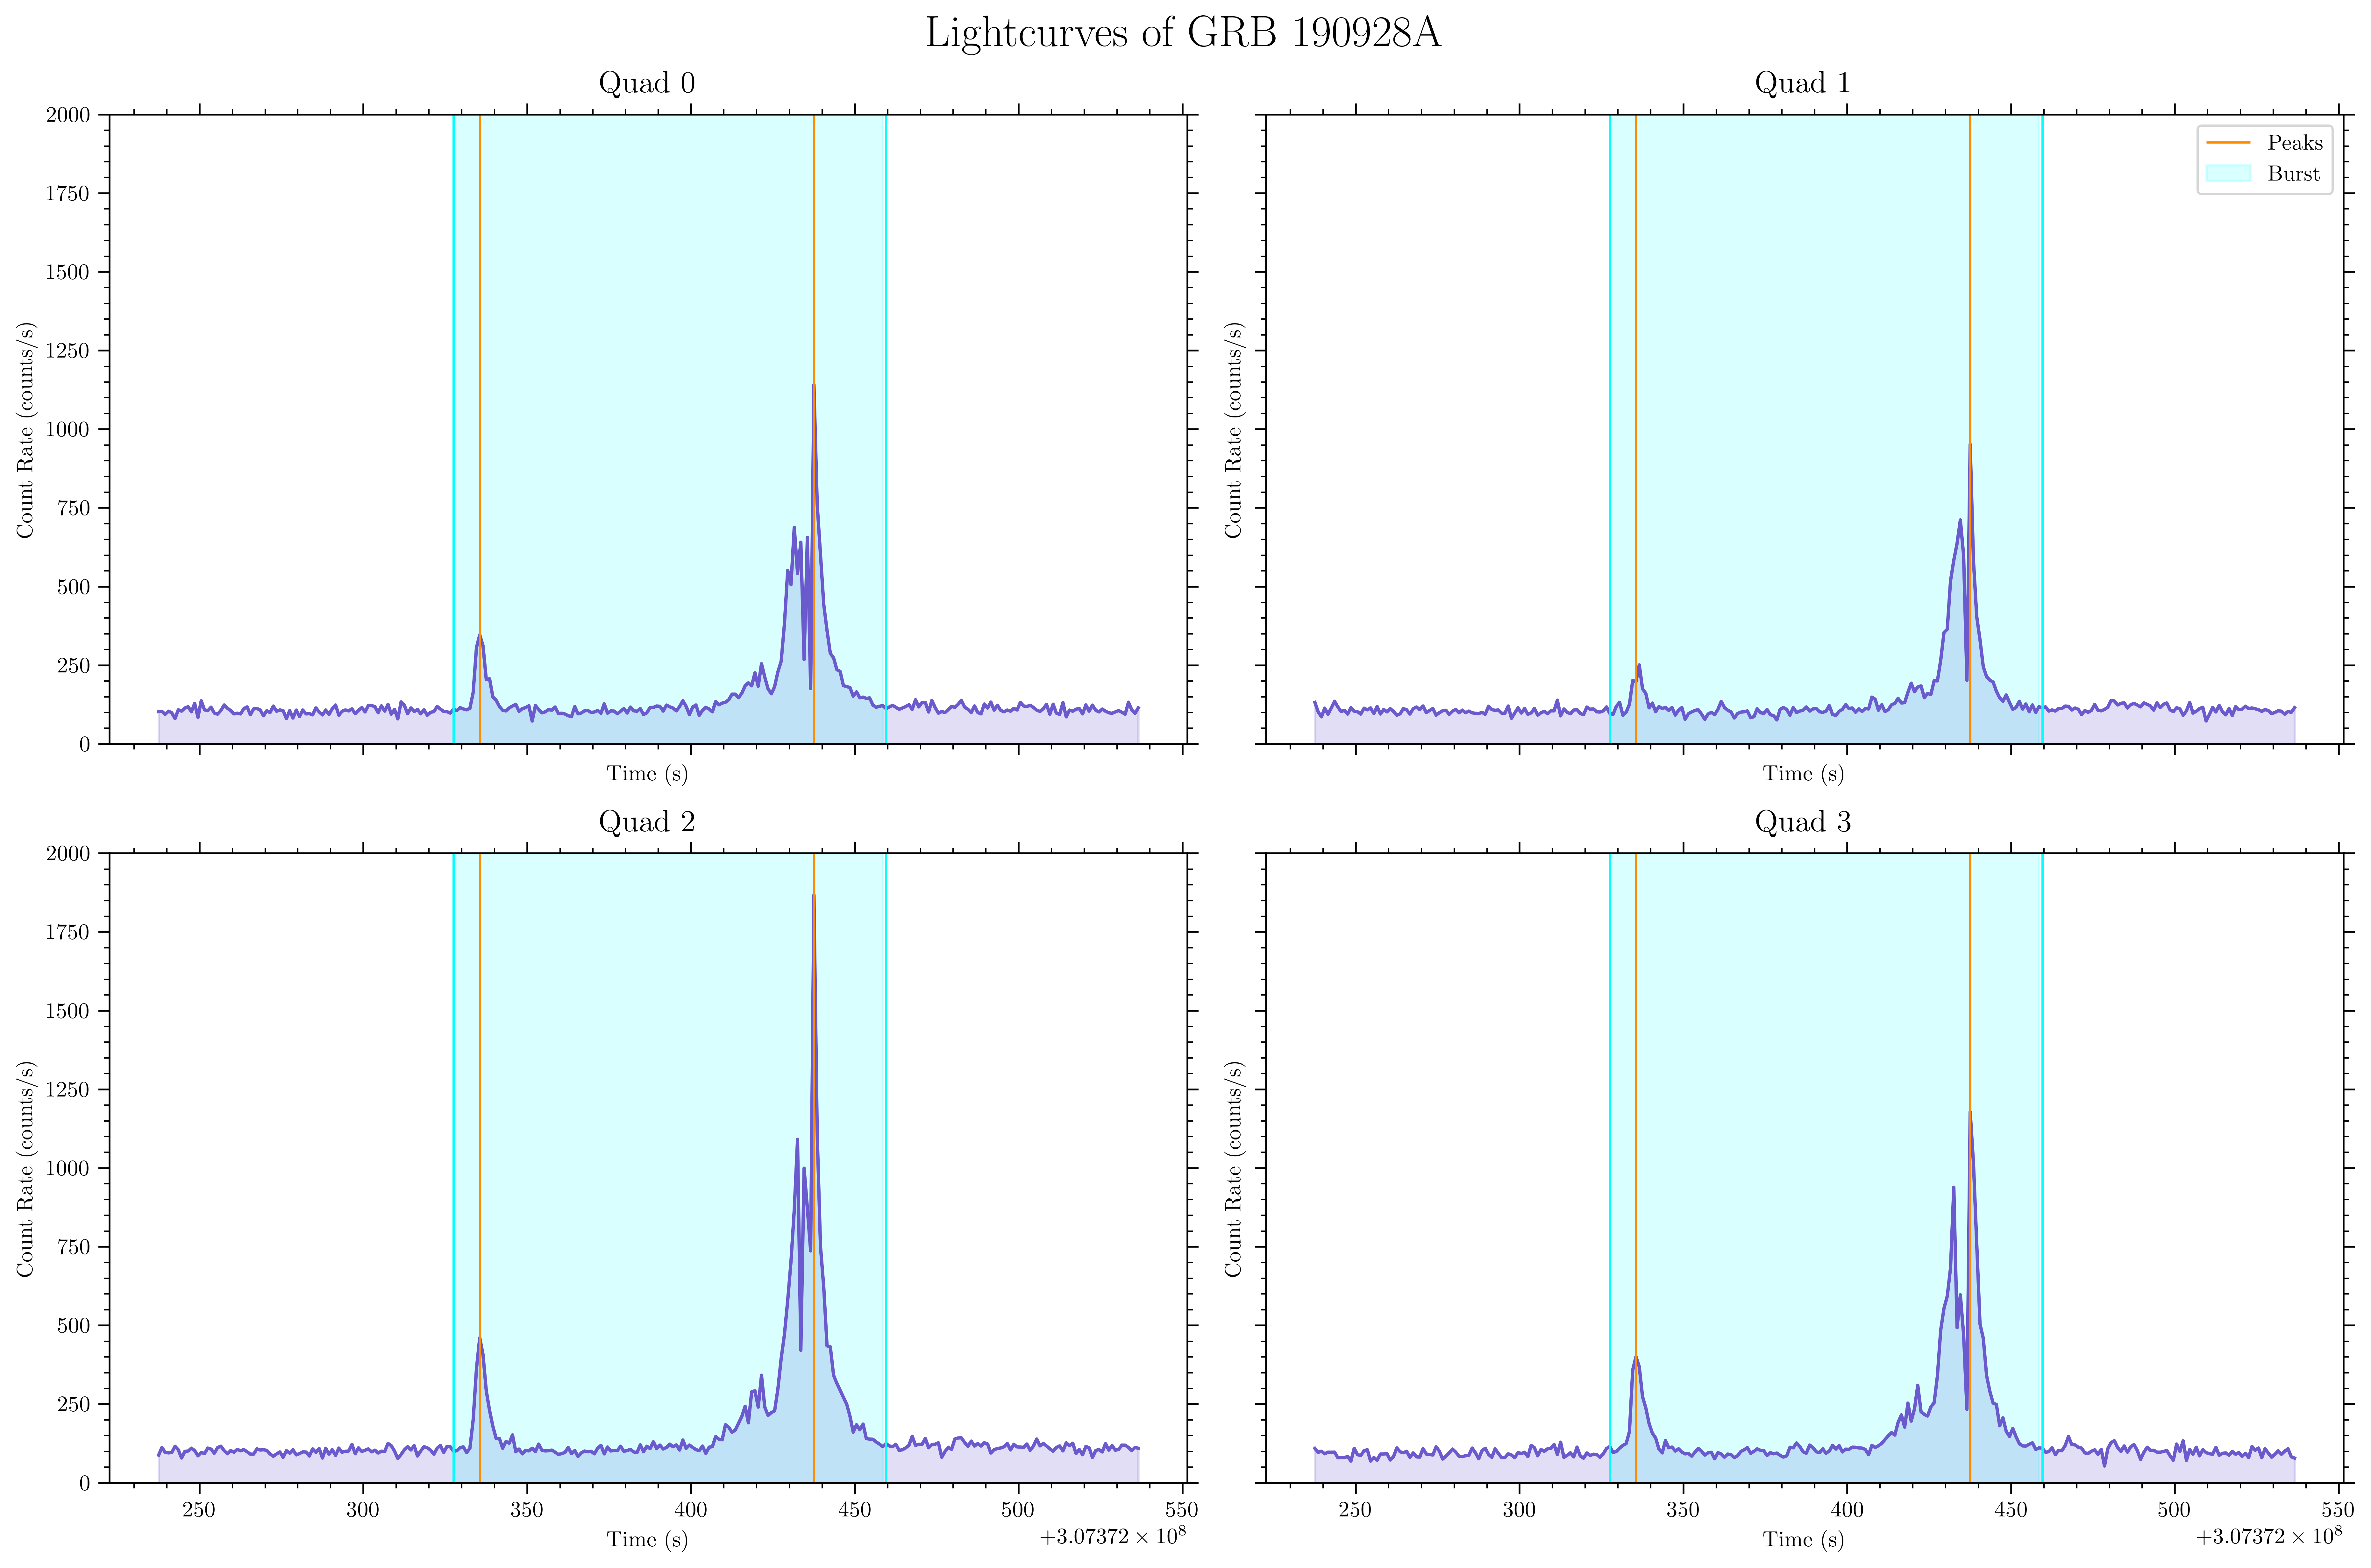

In [57]:
max = int(np.where(lc1_data['RATE'] == np.max(lc1_data['RATE']))[0])
start = max-110
end = max+22

l = [lc1_data, lc2_data, lc3_data, lc4_data]


fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(15, 10), dpi=500)

for i in range(4):
    ax[i//2,i%2].plot(l[i]['TIME'][start-90:end+78], l[i]['RATE'][start-90:end+78], color='slateblue')
    ax[i//2, i%2].set_ylim(0, 2000)
    ax[i//2,i%2].fill_between(l[i]['TIME'][start-90:end+78], l[i]['RATE'][start-90:end+78], color='slateblue', alpha=0.2)
    ax[i//2,i%2].vlines(x = [l[i]['TIME'][max], l[i]['TIME'][max-102]],ymin=0, ymax=2000, color = 'darkorange', label = 'Peaks', linewidth=1)
    ax[i//2,i%2].vlines(x = [l[i]['TIME'][end], l[i]['TIME'][start]], ymin=0, ymax=2000, color = 'cyan', linewidth=1)
    ax[i//2,i%2].fill_between(l[i]['TIME'][start:end], 2000, color='cyan', alpha=0.15, label='Burst')
    ax[i//2,i%2].set_title('Quad '+str(i), fontsize=14, pad=10)
    ax[i//2,i%2].set_xlabel('Time (s)')
    ax[i//2,i%2].set_ylabel('Count Rate (counts/s)')
    if i//2==0 and i%2==1:
        ax[i//2,i%2].legend()
fig.suptitle('Lightcurves of GRB 190928A', fontsize=20)
fig.tight_layout()

In [ ]:
# plt.figure(figsize = (15, 10), dpi=500)
# plt.plot(l[0]['TIME'], l[0]['RATE'], color='slateblue', label='Quad 0')
# plt.ylim(0, 1300)
# plt.xlim(np.min(l[0]['TIME']), np.max(l[0]['TIME']))
# plt.fill_between(l[0]['TIME'], l[0]['RATE'], color='slateblue', alpha=0.2)
# plt.fill_between(l[0]['TIME'][5050:5700], 1300, color='salmon', alpha=0.2, label='South Atlantic Anomaly')
# plt.vlines(x = [l[0]['TIME'][5050], l[0]['TIME'][5700]],ymin=0, ymax=1300, color = 'salmon',linewidth=1)
# plt.legend()
# plt.title('Lightcurve of GRB 190928A: Quadrant 0', fontsize=20, pad=10)
# plt.xlabel('Time (s)', fontsize=15)
# plt.ylabel('Count Rate (counts/s)', fontsize=15)

In [ ]:
# pha = 'data/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.pha'

# pha_data = fits.open(pha)[1].data
# fits.open(pha)[1].header
# plt.figure(figsize=(8, 6), dpi=500)
# plt.plot(20 + ((200-20)/512)*np.arange(512), pha_data['COUNTS'], color='salmon')
# plt.fill_between(20 + ((200-20)/512)*np.arange(512), pha_data['COUNTS'], color='salmon', alpha=0.2)
# plt.xlabel('Energy (keV)', labelpad=10, fontsize=13)
# plt.ylabel('Counts', labelpad=10, fontsize=13)
# plt.title('Spectrum of GRB 190928A: Quadrant 0', fontsize=16, pad=10)

In [19]:
#time of grb
duration = lc4_data['TIME'][end] - lc4_data['TIME'][start]
print("The duration of the GRB is " + str(duration) + " seconds")

The duration of the GRB is 132.0 seconds


**Filtering and detrending the data**

In [59]:
lc1_filtered, *_ = filter_and_detrend(lc1, start, end, 3)
lc2_filtered, *_ = filter_and_detrend(lc2, start, end, 3)
lc3_filtered, *_ = filter_and_detrend(lc3, start, end, 3)
lc4_filtered, *_ = filter_and_detrend(lc4, start, end, 3)

l_f = [lc1_filtered, lc2_filtered, lc3_filtered, lc4_filtered]

fig, ax = plt.subplots(4,1, sharex=True, sharey=True, figsize=(16,18), dpi=500)

for i in range(4):
    ax[i].plot(l_f[i]['TIME'], l_f[i]['RATE'], color='slateblue')
    ax[i].set_title('Quad '+str(i), fontsize=15, pad=10)
    ax[i].set_xlabel('Time (s)', fontsize=13)
    ax[i].set_ylabel('Count Rate (counts/s)', fontsize=13)
fig.suptitle('Filtered Lightcurves of GRB 190928A', fontsize=20, y=0.99)
fig.tight_layout()

**Estimating the noise and calculating SNR**

Method 1 - Using RMS value of noise and peak value of signal
The SNR of the GRB in Quad 0 is 92.26546
The SNR of the GRB in Quad 1 is 77.45521
The SNR of the GRB in Quad 2 is 170.29362
The SNR of the GRB in Quad 3 is 102.121346


Method 2 - Using mean of absolute value of noise and peak value of signal
The SNR of the GRB in Quad 0 is 116.69009
The SNR of the GRB in Quad 1 is 96.82235
The SNR of the GRB in Quad 2 is 212.06691
The SNR of the GRB in Quad 3 is 128.6901


Method 3 - Adding the counts in the peak and noise regions
The SNR of the GRB in Quad 0 is 8.177767178016799
The SNR of the GRB in Quad 1 is 5.839933389330369
The SNR of the GRB in Quad 2 is 14.040108251005691
The SNR of the GRB in Quad 3 is 11.576909233056835


Method 4 - Modelling the noise as a gaussian
The SNR of the GRB in Quad 0 is 32.40541794369179
The SNR of the GRB in Quad 1 is 26.134010051347545
The SNR of the GRB in Quad 2 is 55.87136086770776
The SNR of the GRB in Quad 3 is 35.64376734588042




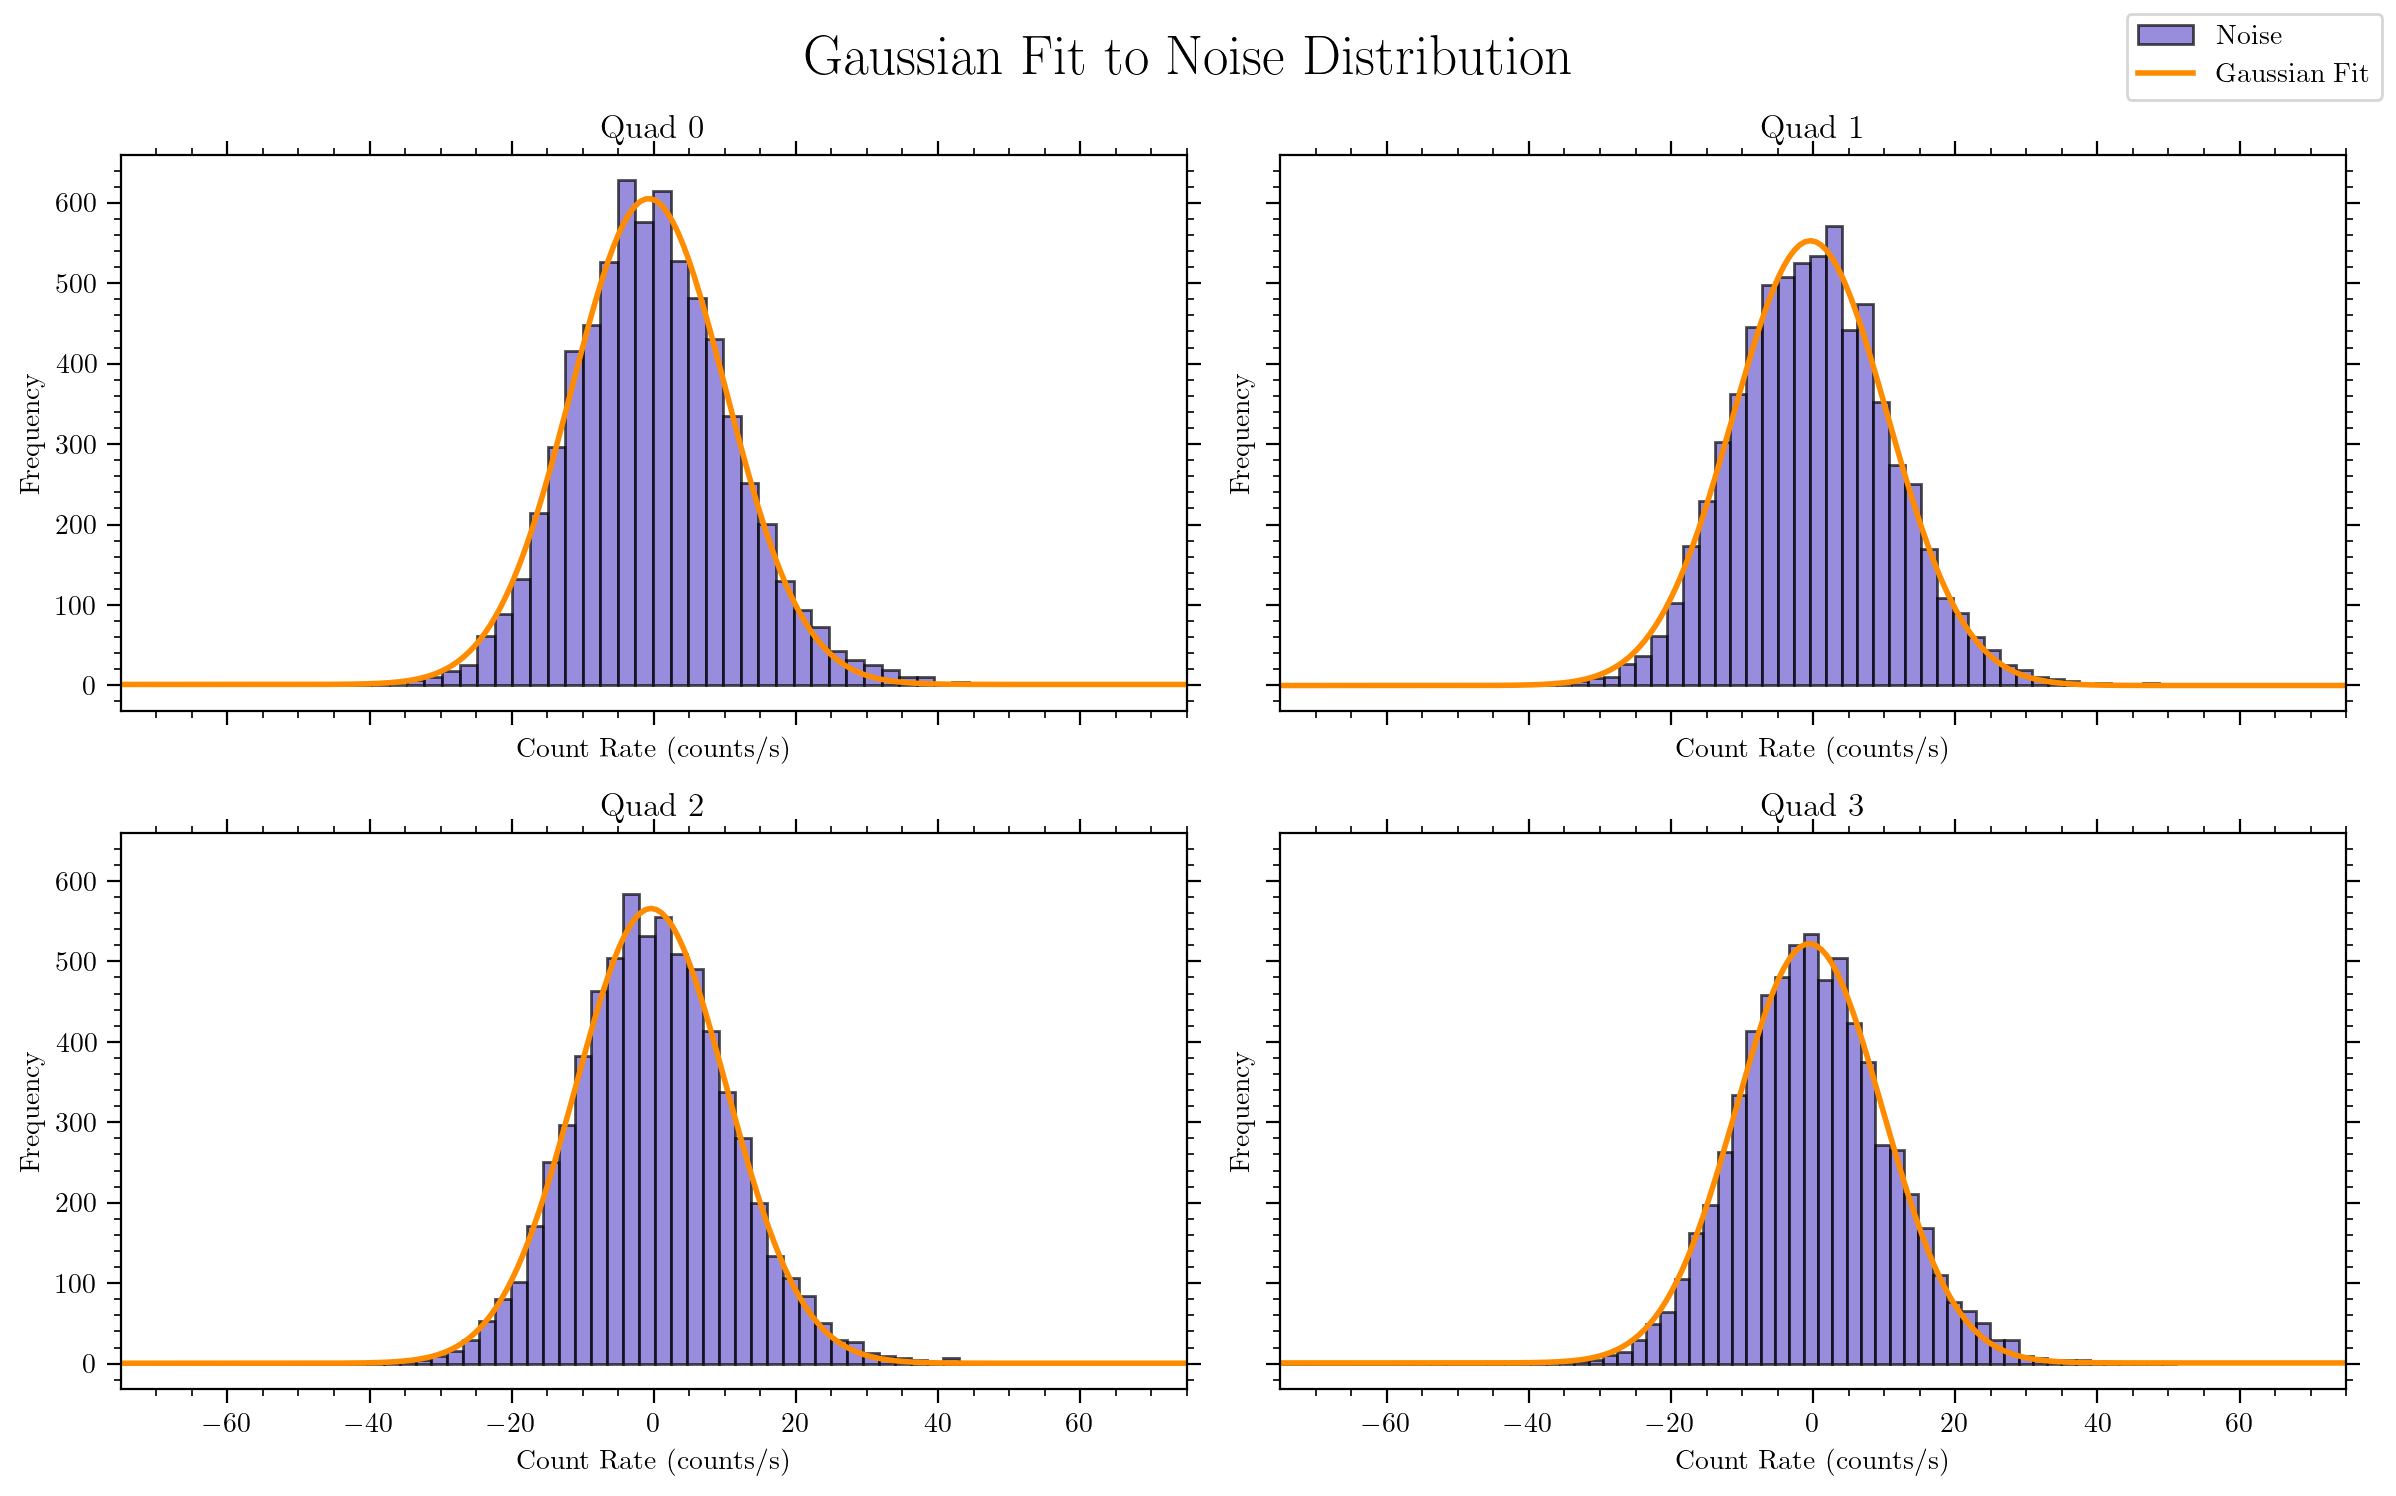

In [45]:
lc = [lc1, lc2, lc3, lc4]

p = ['Using RMS value of noise and peak value of signal', \
     'Using mean of absolute value of noise and peak value of signal', \
     'Adding the counts in the peak and noise regions', \
     'Modelling the noise as a gaussian']

f = [snr_rms, snr_abs, snr_counts, snr_gauss]

for i in range(4):
    print("Method " + str(i+1) + " - " + p[i])
    for j in range(4):
        if i==3:
            print("The SNR of the GRB in Quad " + str(j) + " is " + str(f[i](lc[j], start, end)[0]))
        else:
            print("The SNR of the GRB in Quad " + str(j) + " is " + str(f[i](lc[j], start, end)))
    print("\n")


fig1, ax1 = plt.subplots(2,2, sharex=True, sharey=True, figsize=(12, 7.5), dpi=200)

for i in range(4):
    noise = snr_gauss(lc[i], start, end)[1]
    x = np.linspace(-75, 75, 200)
    popt = snr_gauss(lc[i], start, end)[3]
    ax1[i//2, i%2].hist(noise, bins=80, color='slateblue', label='Noise', alpha=0.69, edgecolor='k')
    ax1[i//2, i%2].plot(x, gaussian(x, *popt), color='darkorange', label='Gaussian Fit', linewidth=2)
    ax1[i//2, i%2].set_xlim(-75,75)
    ax1[i//2, i%2].set_title('Quad ' + str(i))
    ax1[i//2, i%2].set_xlabel('Count Rate (counts/s)')
    ax1[i//2, i%2].set_ylabel('Frequency')
fig1.legend(['Noise', 'Gaussian Fit'])
fig1.suptitle("Gaussian Fit to Noise Distribution", fontsize=20)
fig1.tight_layout()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 400.

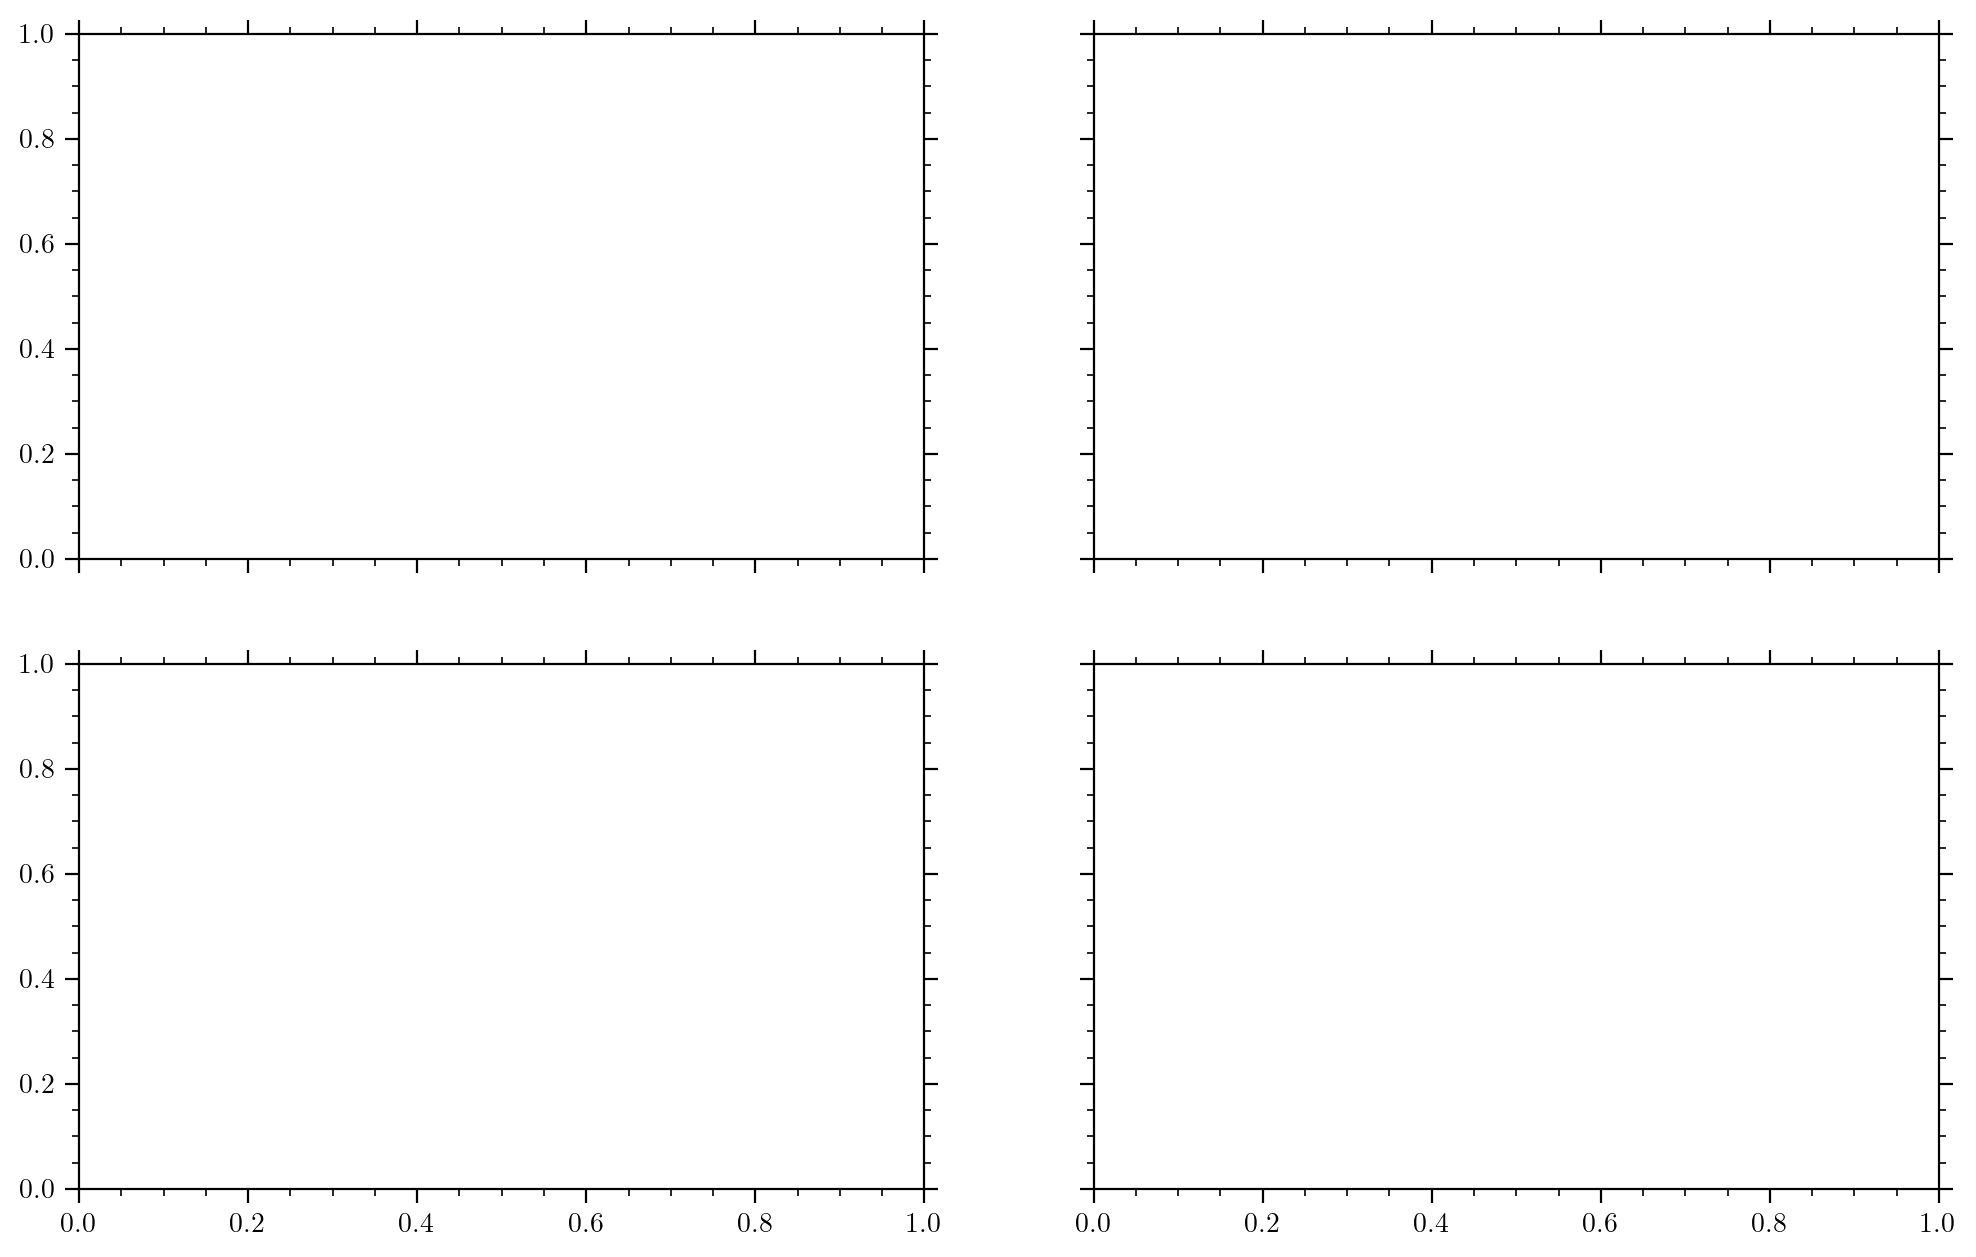

In [47]:
fig2, ax2 = plt.subplots(2,2, sharex=True, sharey=True, figsize=(12, 7.5), dpi=200)

for i in range(4):
    noise = snr_pois(lc[i], start, end)[1]
    bins = snr_pois(lc[i], start, end)[2]
    popt = snr_pois(lc[i], start, end)[3]
    print(popt)
    x = np.arange(0,200)
    ax2[i//2, i%2].hist(noise, bins=bins, color='slateblue', label='Noise')
    ax2[i//2, i%2].plot(x, pois(x, *popt), marker = 'o', linestyle = '', color='darkorange', label='Poisson Fit')
    ax2[i//2, i%2].set_title('Quad ' + str(i))
    ax2[i//2, i%2].set_xlabel('Count Rate (counts/s)')
    ax2[i//2, i%2].set_ylabel('Frequency')
    # if i//2 == 0 and i%2 == 1: ax[i//2, i%2].legend()
fig2.legend(['Noise', 'Poisson Fit'])
fig2.suptitle("Poisson Fit to Noise Distribution", fontsize=20)
fig2.tight_layout()
fig2.show()

**Detector Plane Histograms**

In [17]:
evt = fits.open('data/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean.evt')
data = evt[1].data
one = (np.where(data['TIME'] > int(lc1_data['TIME'][max-10])))[0]
two = (np.where(data['TIME'] < int(lc1_data['TIME'][max+10])))[0]

print(np.max(two)-np.min(one))

evt[1].data = evt[1].data[min(one):np.max(two)]
evt[2].data = evt[2].data[min(one):np.max(two)]
evt[3].data = evt[3].data[min(one):np.max(two)]
evt[4].data = evt[4].data[min(one):np.max(two)]

#evt.writeto('test/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean.evt', overwrite=True)

8578


In [18]:
noise = fits.open('data/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean.evt')
data = noise[1].data

noise[1].data = noise[1].data[100000:108578]
noise[2].data = noise[2].data[100000:108578]
noise[3].data = noise[3].data[100000:108578]
noise[4].data = noise[4].data[100000:108578]

noise.writeto('noise/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean.evt', overwrite=True)

Filename: test/dpigen_out.dph
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      64   ()      
  1  Q0            1 ImageHDU        67   (64, 64)   int32   
  2  Q1            1 ImageHDU        67   (64, 64)   int32   
  3  Q2            1 ImageHDU        67   (64, 64)   int32   
  4  Q3            1 ImageHDU        67   (64, 64)   int32   
  5  FULL_DPH      1 ImageHDU        40   (128, 128)   int32   
Filename: noise/dpigen_out.dph
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      64   ()      
  1  Q0            1 ImageHDU        67   (64, 64)   int32   
  2  Q1            1 ImageHDU        67   (64, 64)   int32   
  3  Q2            1 ImageHDU        67   (64, 64)   int32   
  4  Q3            1 ImageHDU        67   (64, 64)   int32   
  5  FULL_DPH      1 ImageHDU        40   (128, 128)   int32   


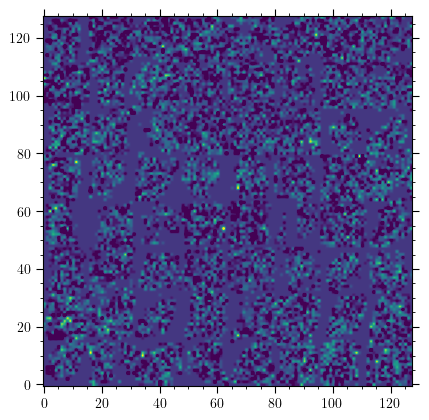

In [19]:
dph_burst = fits.open('test/dpigen_out.dph')
dph_burst.info()
dph_noise = fits.open('noise/dpigen_out.dph')
dph_noise.info()
clean_data = dph_burst[5].data - dph_noise[5].data
mean, median, std = sigma_clipped_stats(clean_data)
plt.imshow(clean_data, vmin=mean-std, vmax=mean+5*std)

plt.gca().invert_yaxis()
plt.show()